
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Pablo Ignacio Muñoz Suárez

**Rol**: 201423552-6

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [5]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

%matplotlib inline

In [6]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [7]:
digits_dict.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [8]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [9]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [7]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
c00       1797 non-null int32
c01       1797 non-null int32
c02       1797 non-null int32
c03       1797 non-null int32
c04       1797 non-null int32
c05       1797 non-null int32
c06       1797 non-null int32
c07       1797 non-null int32
c08       1797 non-null int32
c09       1797 non-null int32
c10       1797 non-null int32
c11       1797 non-null int32
c12       1797 non-null int32
c13       1797 non-null int32
c14       1797 non-null int32
c15       1797 non-null int32
c16       1797 non-null int32
c17       1797 non-null int32
c18       1797 non-null int32
c19       1797 non-null int32
c20       1797 non-null int32
c21       1797 non-null int32
c22       1797 non-null int32
c23       1797 non-null int32
c24       1797 non-null int32
c25       1797 non-null int32
c26       1797 non-null int32
c27       1797 non-null int32
c28       1797 non-null int32
c29       1797 non-null

In [8]:
numbers= []
for i in range(0,10):
    numbers.append(digits.loc[digits["target"]==i])

In [9]:
numbers[0].describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,178.0,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.0,178.0,178.000000,...,178.0,178.0,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.0,178.0
mean,0.0,0.022472,4.185393,13.095506,11.297753,2.926966,0.033708,0.0,0.0,0.887640,...,0.0,0.0,0.005618,4.157303,13.561798,13.325843,5.438202,0.275281,0.0,0.0
std,0.0,0.211400,2.946684,2.246625,3.417485,3.232996,0.180985,0.0,0.0,1.778327,...,0.0,0.0,0.074953,2.715924,2.013823,2.717490,4.001285,0.931287,0.0,0.0
min,0.0,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.0,0.0
25%,0.0,0.000000,2.000000,12.000000,9.000000,1.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,2.000000,12.000000,12.000000,2.000000,0.000000,0.0,0.0
50%,0.0,0.000000,4.000000,13.000000,12.000000,2.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,4.000000,14.000000,14.000000,5.000000,0.000000,0.0,0.0
75%,0.0,0.000000,6.000000,15.000000,14.000000,5.000000,0.000000,0.0,0.0,1.000000,...,0.0,0.0,0.000000,6.000000,15.000000,15.000000,8.000000,0.000000,0.0,0.0
max,0.0,2.000000,12.000000,16.000000,16.000000,14.000000,1.000000,0.0,0.0,13.000000,...,0.0,0.0,1.000000,11.000000,16.000000,16.000000,16.000000,7.000000,0.0,0.0


In [10]:
# La memoria utilizada para esto es
import sys
Memoria = digits.memory_usage()
total = (Memoria[1]*65)/1000 
                            
print(total, 'kilobytes')

467.22 kilobytes


In [11]:
for i in range(0,10):
    print("hay %f Registros para la clase %s" % ( numbers[i].shape[0] , i ) )


hay 178.000000 Registros para la clase 0
hay 182.000000 Registros para la clase 1
hay 177.000000 Registros para la clase 2
hay 183.000000 Registros para la clase 3
hay 181.000000 Registros para la clase 4
hay 182.000000 Registros para la clase 5
hay 181.000000 Registros para la clase 6
hay 179.000000 Registros para la clase 7
hay 174.000000 Registros para la clase 8
hay 180.000000 Registros para la clase 9


### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [12]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

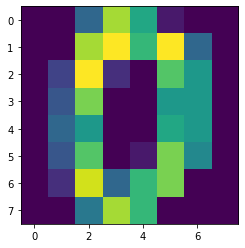

In [13]:
plt.imshow(digits_dict["images"][0])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

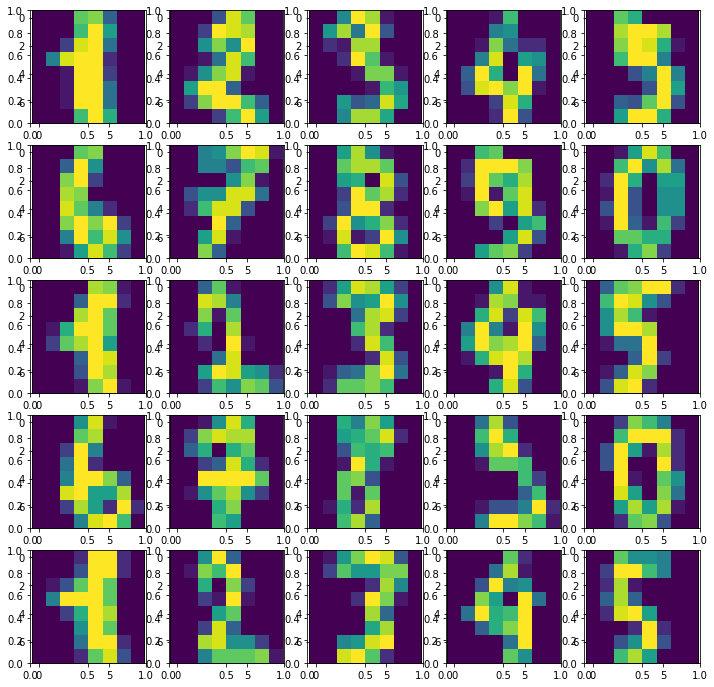

In [14]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1, nx*ny +1):
    img = digits_dict["images"][i]
    fig.add_subplot(nx, ny, i)
    plt.imshow(img)
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [21]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [23]:
#Logistic Regresor

tiempos_ejecucion = []
lista_nombres = ["Logistic Regresor","Random Forest","knn","Logistic Regresor -","Random Forest-","knn-"]
tiempo_inicial = time.time()
clf = LogisticRegression()
clf.fit(X_train,y_train)
tiempo_final = time.time()
tiempos_ejecucion.append(tiempo_final-tiempo_inicial)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
#random forest
tiempo_inicial = time.time()
rf = RandomForestClassifier(max_depth=12, random_state=0)
rf.fit(X_train,y_train)
tiempo_final = time.time()
tiempos_ejecucion.append(tiempo_final-tiempo_inicial)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
from sklearn.neighbors import KNeighborsClassifier

tiempo_inicial = time.time()
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
tiempo_final = time.time()
tiempos_ejecucion.append(tiempo_final-tiempo_inicial)

In [26]:
clf.score( X_test, y_test)

0.9596662030598053

In [27]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[66,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 66,  2,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0, 66,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 69,  0,  1,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 76,  0,  0,  0,  1,  0],
       [ 0,  2,  1,  0,  0, 78,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  1, 68,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 70,  0,  1],
       [ 0,  2,  0,  0,  0,  1,  0,  0, 62,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  1,  5, 69]], dtype=int64)

In [28]:
f1_score(y_test, y_pred,average='micro')

0.9596662030598053

In [29]:
rf.score( X_test, y_test)

0.9568845618915159

In [30]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[66,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 71,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 66,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  3, 64,  0,  1,  0,  0,  2,  0],
       [ 0,  0,  0,  0, 75,  1,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  1, 78,  2,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0, 68,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 70,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0, 62,  1],
       [ 0,  1,  0,  2,  0,  5,  0,  0,  1, 68]], dtype=int64)

In [31]:
f1_score(y_test, y_pred,average='micro')

0.9568845618915159

In [32]:
knn.score( X_test, y_test)

0.9888734353268428

In [33]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[67,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 72,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 66,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 70,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 78,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 81,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 69,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 71,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0, 63,  0],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0, 74]], dtype=int64)

In [34]:
f1_score(y_test, y_pred,average='micro')

0.9888734353268428

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [1]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

In [46]:
cv_results = cross_validate(knn, X, y, cv=10)

In [47]:
cv_results['test_score']

array([0.91891892, 0.97814208, 0.98342541, 0.97222222, 0.97206704,
       0.97206704, 0.98882682, 0.98876404, 0.96045198, 0.96590909])

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


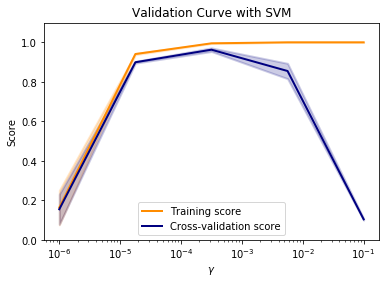

In [48]:
#literal es el código que nos aparece en la documentación

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [49]:
#nuevamente, copiamos el código original de la documentación

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

NameError: name 'label_binarize' is not defined

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

In [15]:
X = digits.drop(columns="target").values
y = digits["target"].values
X_new = SelectKBest(chi2, k=18).fit_transform(X, y)
X = X_new

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [16]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [17]:
mostar_resultados(digits,knn,nx=5, ny=5,label = "correctos")

NameError: name 'knn' is not defined

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.